1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted digit for 0.jpg is: 0


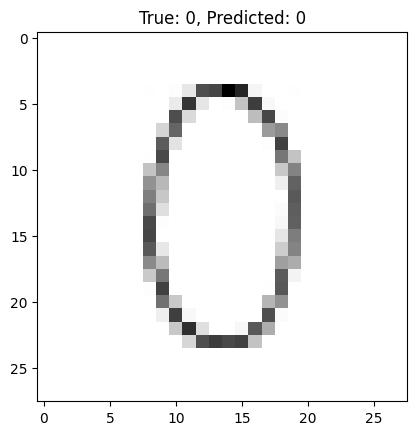

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted digit for 1.jpg is: 1


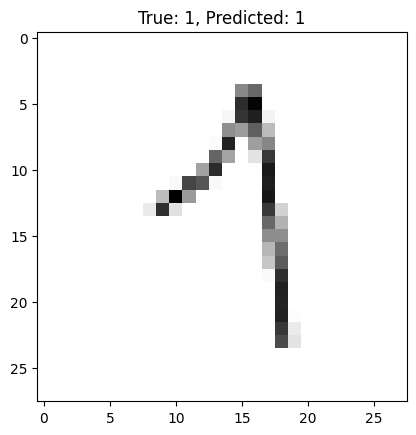

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted digit for 2.jpg is: 2


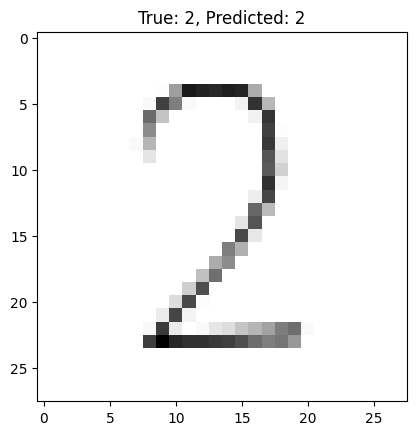

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted digit for 3.jpg is: 3


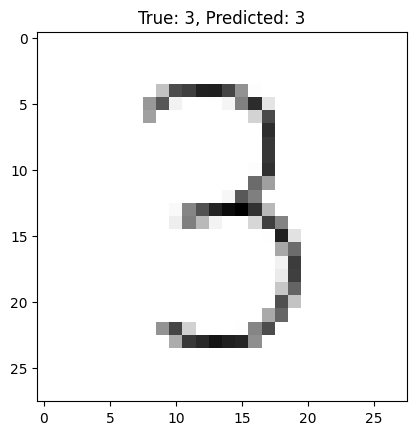

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted digit for 4.jpg is: 4


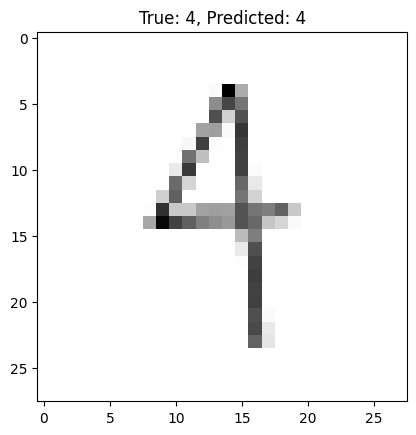

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted digit for 5.jpg is: 5


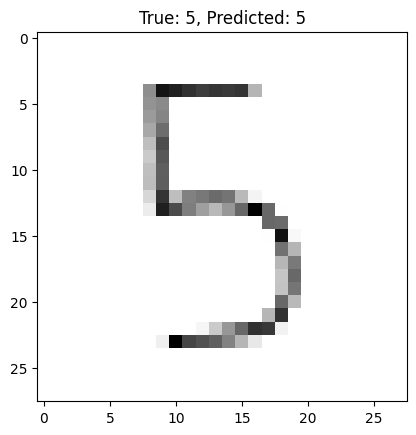

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted digit for 6.jpg is: 6


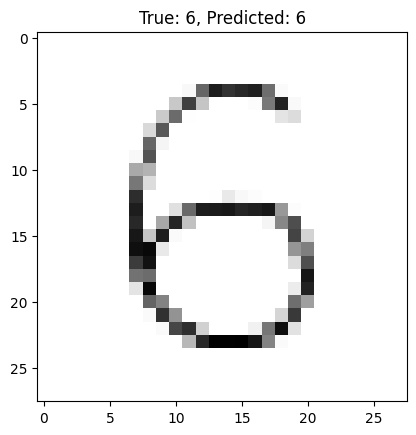

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted digit for 7.jpg is: 7


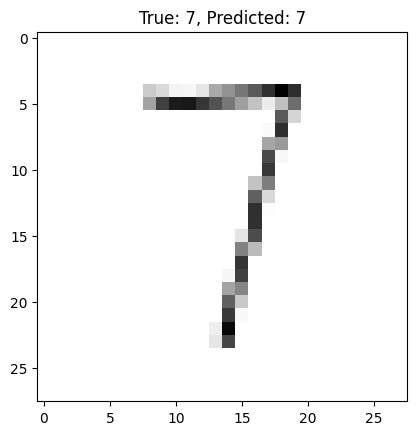

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted digit for 8.jpg is: 8


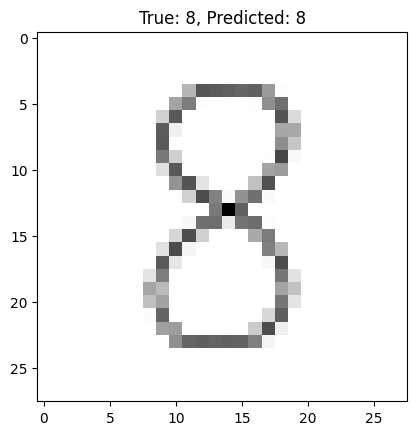

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted digit for 9.jpg is: 9


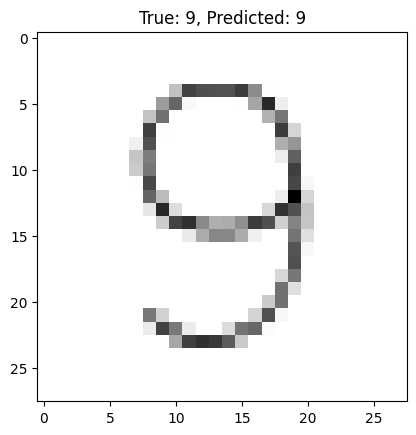

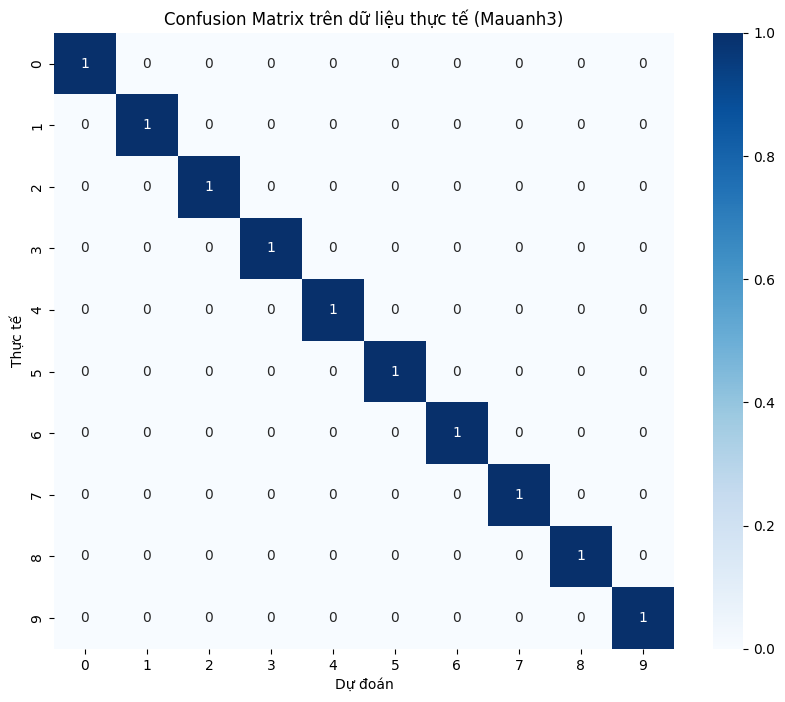

No retraining needed, all predictions were correct.


In [47]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Hàm tiền xử lý hình ảnh
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)
        digit = binary_image[y:y+h, x:x+w]
        max_dim = max(w, h)
        top = (max_dim - h) // 2
        bottom = max_dim - h - top
        left = (max_dim - w) // 2
        right = max_dim - w - left
        digit = cv2.copyMakeBorder(digit, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
        digit = cv2.resize(digit, (20, 20), interpolation=cv2.INTER_AREA)
        final_image = np.zeros((28, 28), dtype=np.uint8)
        final_image[4:24, 4:24] = digit
        final_image = final_image / 255.0
        final_image = final_image[..., np.newaxis]
        return final_image
    else:
        raise ValueError(f"Không tìm thấy chữ số trong hình ảnh {image_path}")

# Tải mô hình
model = tf.keras.models.load_model('../handwritten_digits.keras',
                                   custom_objects={'softmax_v2': tf.keras.activations.softmax})

# Danh sách để lưu trữ dữ liệu huấn luyện lại và nhãn
X_retrain = []
y_retrain = []
true_labels = []
pred_labels = []
image_number = 0

# Dự đoán trên các hình ảnh thực tế
while os.path.isfile(f"../human2/{image_number}.jpg"):
    try:
        # Tiền xử lý hình ảnh
        processed_img = preprocess_image(f"../human2/{image_number}.jpg")

        # Dự đoán
        prediction = model.predict(np.array([processed_img]))
        predicted_digit = np.argmax(prediction, axis=1)[0]
        true_digit = image_number  # Nhãn đúng từ tên file
        print(f"Predicted digit for {image_number}.jpg is: {predicted_digit}")

        # Lưu nhãn thực tế và dự đoán
        true_labels.append(true_digit)
        pred_labels.append(predicted_digit)

        # Nếu dự đoán sai, thêm vào tập huấn luyện lại
        if predicted_digit != true_digit:
            print(f"Wrong prediction for {image_number}.jpg: True={true_digit}, Predicted={predicted_digit}, adding to retraining set.")
            X_retrain.append(processed_img)
            y_retrain.append(true_digit)

        # Hiển thị hình ảnh đã tiền xử lý
        plt.imshow(processed_img.squeeze(), cmap=plt.cm.binary)
        plt.title(f"True: {true_digit}, Predicted: {predicted_digit}")
        plt.show()

    except Exception as e:
        print(f"Error occurred on image {image_number}.jpg: {str(e)}")
    finally:
        image_number += 1

# Hiển thị confusion matrix
if true_labels:
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix trên dữ liệu thực tế (Mauanh3)')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()
    
# Huấn luyện lại mô hình nếu có dữ liệu sai
if X_retrain:
    # Tải dữ liệu MNIST để làm tập kiểm định
    mnist = tf.keras.datasets.mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Chuẩn hóa và thêm chiều kênh cho cả X_train và X_test
    X_train = X_train / 255.0
    X_train = X_train[..., np.newaxis]  # Thêm chiều kênh: (60000, 28, 28) -> (60000, 28, 28, 1)
    X_test = X_test / 255.0
    X_test = X_test[..., np.newaxis]   # (10000, 28, 28) -> (10000, 28, 28, 1)

    # Chuẩn bị dữ liệu huấn luyện lại
    X_retrain = np.array(X_retrain)
    y_retrain = np.array(y_retrain)

    # Kết hợp với một phần dữ liệu MNIST
    num_mnist_samples = len(X_retrain) * 5
    X_combined = np.concatenate([X_retrain, X_train[:num_mnist_samples]], axis=0)
    y_combined = np.concatenate([y_retrain, y_train[:num_mnist_samples]], axis=0)

    # Huấn luyện lại mô hình
    model.fit(X_combined, y_combined, epochs=5, validation_data=(X_test, y_test))
    print("Model retrained with new data.")
    model.save('../handwritten_digits.keras')
else:
    print("No retraining needed, all predictions were correct.")

In [48]:
# Plotting accuracy and loss
# Accuracy plot

# Kiểm tra lịch sử huấn luyện trước khi vẽ biểu đồ
if hasattr(model, 'history') and model.history.history:
    history = model.history.history

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.get('accuracy', []), marker='o', color='r', label='Training Accuracy')
    plt.plot(history.get('val_accuracy', []), marker='o', color='b', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.get('loss', []), marker='o', color='r', label='Training Loss')
    plt.plot(history.get('val_loss', []), marker='o', color='b', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()
else:
    print("No training history available.")

No training history available.
